In [1]:
import os
 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import phydrus as ps


/var/folders/v8/fyfv2jmd0jl6wjc38l1cz4wc0000gn/T/ipykernel_24950/3213397020.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
os.getcwd()

'/Users/echry/Documents/PhD/UPWater/Modeling/Hydrus-Phreeqc'

In [4]:
#Folder where the Hydrus files are to be stored
os.chdir("source_mcmc")
ws = "output_KM"
#exe = os.getcwd()
exe=os.path.join(os.getcwd(), "hydrus")
# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="KM",
              time_unit="days", length_unit="cm", mass_units= 'mmol', print_screen=True)
ml.basic_info['lChem']=True
ml.add_time_info( tmax=515, print_times=True);

In [5]:
from pandas import DataFrame, DatetimeIndex, MultiIndex
from numpy import arange

def get_empty_material_df(self, n=1):
    """
    Get an empty DataFrame with the soil parameters as columns.
    Parameters
    ----------
    n: int, optional
    Number of materials to add.

    return
    ----------
    pandas.DataFrame
        Pandas DataFrame with the soil parameters as columns.

    Examples
    --------

     >>> m = ml.get_empty_material_df(n=2)
     >>> m.loc[1:2] = [[0.08, 0.3421, 0.03, 5, 1, -0.5],
     >>>               [0.08, 0.3421, 0.03, 5, 0.1, -0.5]]
     >>> ml.add_material(m)


    """
    models = {
            0: ["thr", "ths", "Alfa", "n", "Ks", "l"],
            1: ["thr", "ths", "Alfa", "n", "Ks", "l", "thm", "tha", "thk",
                "Kk"],
            2: ["thr", "ths", "Alfa", "n", "Ks", "l"],
            3: ["thr", "ths", "Alfa", "n", "Ks", "l"],
            4: ["thr", "ths", "Alfa", "n", "Ks", "l"],
            5: ["thr", "ths", "Alfa", "n", "Ks", "l", "w", "Alfa2", "n2"],
            6: ["thr", "ths", "Alfa", "n", "Ks", "l", "thr_im", "ths_im",
                "omega"],
            7: ["thr", "ths", "Alfa", "n", "Ks", "l", "thr_im", "ths_im",
                "Alfa_im", "n_im", "Ka"],
            9: list(range(17))
        }

    level2 = models[self.water_flow["iModel"]]
    level1 = ["water"] * len(level2)

    if self.solute_transport is not None:
        models = {
                0: ["bulk.d", "DisperL", "frac", "mobile_wc"],
                1: ["bulk.d", "DisperL", "frac", "mobile_wc"],
                2: ["bulk.d", "DisperL", "frac", "mobile_wc"],
                3: [],
                4: [],
                5: [],
                6: [],
                7: [],
                8: []
            }

        cols2 = models[self.solute_transport["iNonEqual"]]
        level1.extend(["solute"] * len(cols2))
        level2.extend(cols2)

        columns = MultiIndex.from_arrays([level1, level2])

        return DataFrame(columns=columns, index=arange(1, n + 1),
                         data=0, dtype=float)

In [6]:
def add_material(self, material):
    """
    Method to add a material to the model.

    Parameters
    ----------
    material: pandas.DataFrame
        Pandas DataFrame with the parameter names as columns and the
        values for each material as one row. The index for each is the
        reference number for each material and must be unique. The
        number of columns depends on the water flow model that has been
        chosen.

    Examples
    --------
    >>> m = pd.DataFrame({1: [0.08, 0.3421, 0.03, 5, 1, -0.5]}, index=[1],
                          columns=["thr", "ths", "Alfa", "n" "Ks", "l"])
    >>> ml.add_material(m)

    See Also
    --------
    phydrus.Model.get_empty_material_df

    """
    self.materials = material

In [7]:
ml.add_waterflow(model=0,top_bc=3,bot_bc=4)
ml.water_flow["WLayer"] = True
ml.add_solute_transport(tpulse=100, model=0, top_bc=1, bot_bc=0, maxit=20, epsi=1)#bot_bc=-1 top_bc=-1

m = get_empty_material_df(ml, n=4)
m.loc[0:4] = [[0.047, 0.42, 0.017, 1.21, 2, 5,1.45,35,1,0],
              [0.047, 0.41, 0.018, 1.23, 19.14,5,1.45,35,1,0],
              [0, 0.432, 0.0336, 1.1701, 8.58, -5, 1.45,35,1,0],
              [0, 0.465, 0.1284, 1.1160, 195.15, -5, 1.45,35,1,0]]
add_material(ml,m)

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/profile.py:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna("")


<Axes: xlabel='h [cm]', ylabel='depth [cm]'>

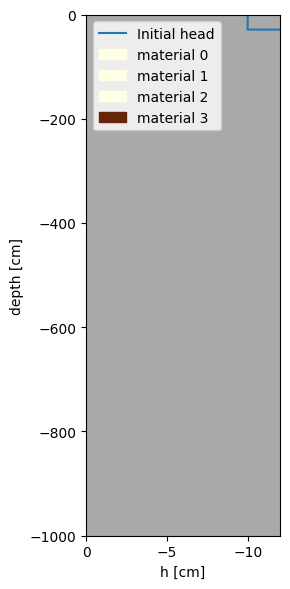

In [8]:
bottom =  [-30,-200,-800,-1000] # Depth of the soil column
nodes = 100 # Dictretize into n nodes
ihead = [-10, -100, -500, -500] # Determine initial pressure head

profile = ps.create_profile(top=0, bot=bottom, dx=1, h=ihead, lay=[1,2,3,4], mat=[1,2,3,4], conc=[3.33e-9, 0, 0, 0])
ml.add_profile(profile)
ml.plots.profile(figsize=(3,6))

In [9]:
os.chdir("../Data_atm")

atm = pd.read_csv("atmosphere_km.csv", index_col=0, delimiter=",")

In [10]:
os.chdir("../source_mcmc")
ml.add_atmospheric_bc(atm, hcrits=0, hcrita=-10000)

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/model.py:493: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6.36363636  6.91666667  6.33783784  6.8125      5.9375      5.40972222
  7.00694444  8.20833333  8.01388889  8.09722222  7.9375      7.69444444
  6.95138889  7.79166667  8.42361111  8.24305556  8.22916667  8.54861111
  8.65277778  8.20138889  8.375       8.75        8.625       8.38888889
  8.46527778  8.          7.1875      8.30555556  8.69444444  7.96527778
  8.26388889  8.26388889  7.73611111  7.3125      7.19444444  7.22222222
  7.11111111  7.64583333  7.74305556  7.68055556  6.83333333  7.3125
  7.60416667  7.6875      8.04861111  8.44444444  7.73611111  7.42657343
  8.28671329  8.70138889  8.86111111  8.84027778  9.5625      8.61805556
  7.55555556  8.49305556  9.60416667 35.26388889 30.65734266  9.01388889
  7.46527778  6.88888889  7.86805556  8.27777778  7.46527778  7.2708333

In [11]:
### Add solutes
sol1 = ml.get_empty_solute_df()
sol1["beta"] = 1
sol1['nu']=0
#sol1["kg"] = 5
#sol1["ks"] = 2
#sol1["mu_lg"] = 0.1
ml.add_solute(sol1, difw=0.69, top_conc=3.33e-09, bot_conc=1.66e-09) #difg=0.19872

In [12]:
#Number of the node -- > write script to get node closest to desired depth
ml.add_obs_nodes([-100, -500, -1000])

In [13]:
ml.write_input()

INFO: Successfully wrote output_KM/SELECTOR.IN


INFO: Successfully wrote output_KM/PROFILE.DAT
INFO: Successfully wrote output_KM/ATMOSPH.IN


In [14]:
ml.simulate()

 ----------------------------------------------------
 |                                                  |
 |                    HYDRUS                        |
 |                                                  |
 |   Code for simulating one-dimensional variably   |
 |    saturated water flow, heat transport, and     |
 |   transport of solutes involved in sequential    |
 |         first-order decay reactions              |
 |                                                  |
 |                  version 4.08                    |
 |                                                  |
 |           Last modified: January, 2009           |
 |                                                  |
 ----------------------------------------------------

 None                                                                    

 reading nodal information
 reading material information
 generating materials
 reading time information
 reading solute transport information
 printing profile informa

INFO: Hydrus-1D Simulation Successful.


     515.0000  3 757887-0.14E+01-0.83E+03 0.00E+00-0.69E+03     0.0    0.   -7.
 Real time [sec]  -2144507219.2500000     


CompletedProcess(args=['/Users/echry/Documents/PhD/UPWater/Modeling/Hydrus-Phreeqc/source_mcmc/hydrus', 'output_KM', '-1'], returncode=0)

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,


array([<Axes: xlabel='Time [days]', ylabel='Bottom Flux'>,
       <Axes: xlabel='Time [days]', ylabel='Cum. Bottom Flux'>],
      dtype=object)

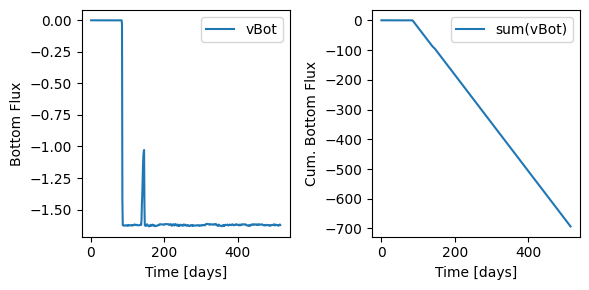

In [15]:
ml.ws_name='output_KM'
ml.plots.water_flow(data="Bottom Flux")

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,


<Axes: xlabel='Time [days]', ylabel='Surface runoff'>

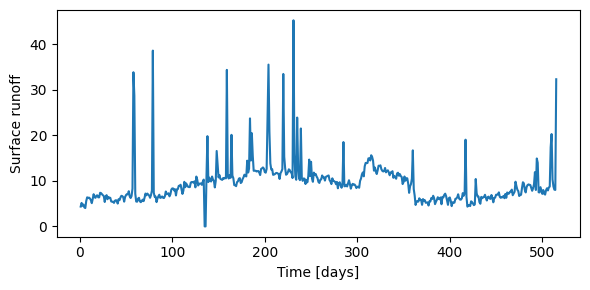

In [16]:
ml.plots.water_flow(data="Surface runoff")

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future versi

<Axes: xlabel='Theta [-]', ylabel='Depth [cm]'>

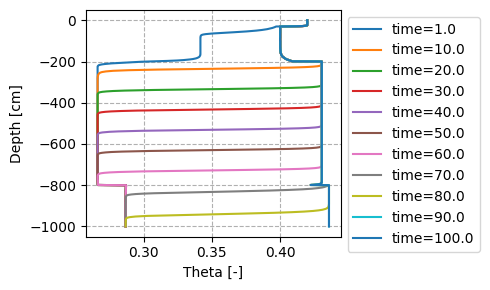

In [17]:
ml.plots.profile_information(data="Water Content",times=[1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:259: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = read_csv(path, skiprows=start, index_col=0, nrows=end - start - 1,


[]

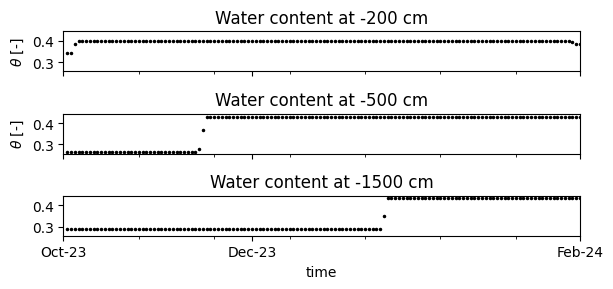

In [18]:
df = ml.read_obs_node()

fig, [ax0, ax1, ax2] = plt.subplots(3,1, figsize=(6,3), sharex=True, sharey=True)
df[ml.obs_nodes[0]]["theta"].plot(ax=ax0, marker=".", c="k", linestyle="", markersize=3)
ax0.set_title("Water content at -200 cm")
ax0.set_ylabel(r"$\theta$ [-]")

df[ml.obs_nodes[1]]["theta"].plot(ax=ax1, marker=".", c="k", linestyle="", markersize=3)
ax1.set_title("Water content at -500 cm")
df[ml.obs_nodes[2]]["theta"].plot( marker=".", c="k", linestyle="", markersize=3)
ax2.set_title('Water content at -1500 cm')
ax1.set_ylabel(r"$\theta$ [-]")
plt.tight_layout()
ax1.set_xlabel("")
ax1.set_xlim(0,137)
ax1.set_xticks([0,50,137])
ax1.set_xticklabels(["Oct-23", "Dec-23", "Feb-24"])

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:259: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = read_csv(path, skiprows=start, index_col=0, nrows=end - start - 1,


<Axes: xlabel='Time [days]', ylabel='Conc'>

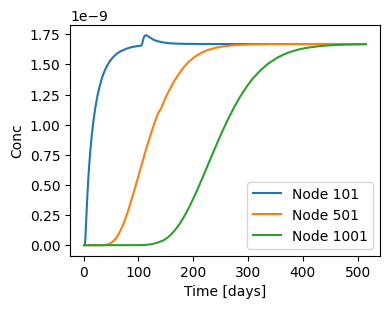

In [19]:
ml.plots.obs_points(data="Conc")

In [20]:
times_bottom = [1, 50, 150, 200, 325, 500]
profile=ml.read_nod_inf(times=times_bottom)

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future versi

In [21]:
def ng_Ltommol_cm3(value, mol_weight):
    ng_ml=value/1000
    nmol_L=(ng_ml*1000)/mol_weight
    return nmol_L/10**9

In [22]:
# Convert concentrations values from mmol/cm3 to ng/L
mol_weight=300.1 #grams PFBS molecular weight

for key in profile:
    profile[key]['Conc_nmol_L']=profile[key]['Conc(1..NS)']*10**9
    profile[key]['Conc_ng_ml']=profile[key]['Conc_nmol_L']*mol_weight/1000
    profile[key]['Conc_ng_L']=profile[key]['Conc_ng_ml']*1000



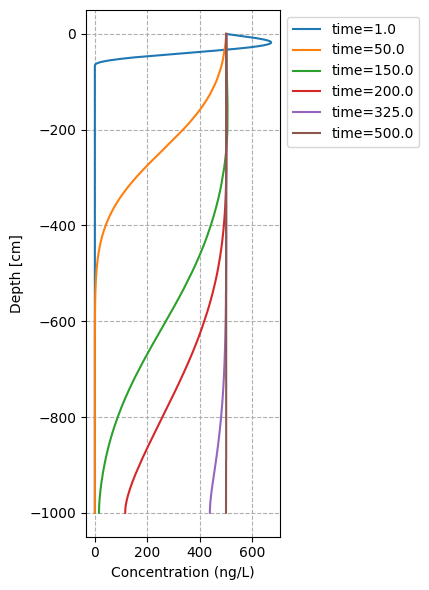

In [23]:
figsize = (3, 6)
#times_bottom = [103, 123, 150]
_, ax = plt.subplots(figsize=figsize)

dfs = profile  # A dictionary of DataFrames
use_cols = ("Conc_ng_L", "Head")

if times_bottom is None or len(times_bottom) > 1:
    for key, df in dfs.items():
        if use_cols[0] in df.columns and "Depth" in df.columns:
            df.plot(x=use_cols[0], y="Depth", ax=ax, label=f"time={key}")
        else:
            print(f"Missing columns in DataFrame with key {key}")
else:
    df = dfs[times_bottom[0]]  #times_bottom[0] maps to a DataFrame
    if use_cols[0] in df.columns and "Depth" in df.columns:
        df.plot(x=use_cols[0], y="Depth", ax=ax, label=f"T {times_bottom[0]}")
    else:
        print(f"Missing columns in DataFrame for time {times_bottom[0]}")

ax.set_xlabel("Concentration (ng/L)")
ax.set_ylabel("Depth [cm]")
ax.grid(linestyle="--")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#plt.tight_layout()
plt.savefig('../Figures/Travel_times_PFBS.png', dpi=600, bbox_inches='tight') # change with your desired Figures output folder
plt.show()

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[time] = read_csv(file, skiprows=s,
/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:320: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future versi

<Axes: xlabel='c [mmol/cm*3]', ylabel='Depth [cm]'>

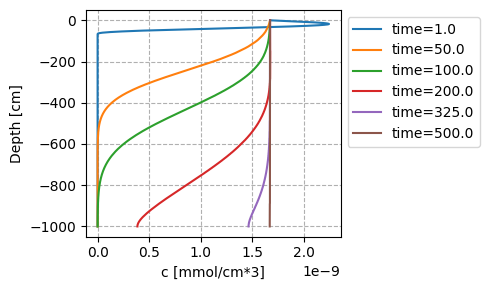

In [24]:
ml.plots.profile_information("Concentration", times=[1, 50, 100, 200, 325, 500])

In [25]:
from __future__ import print_function

import sys
import urllib.request
# Simple Python 3 compatibility adjustment.
if sys.version_info[0] == 2:
    range = xrange

import os
import timeit
import pandas as pd

MODE = 'dll'  # 'dll' or 'com'

if MODE == 'com':
    import phreeqpy.iphreeqc.phreeqc_com as phreeqc_mod
elif MODE == 'dll':
    import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
else:
    raise Exception('Mode "%s" is not defined use "com" or "dll".' % MODE)

In [29]:
### Couple Hydrus - Phreeqc3 for solid and air-water interface sorption

# Load Hydrus results into a DataFrame
hydrus_results = ml.read_obs_node()  # Assume columns: 'Time', 'Pfas'
# Access data for a specific key
specific_key = 101  # Replace this with the node (in our case 101, 501, 1001)
if specific_key in hydrus_results:
    specific_data = hydrus_results[specific_key]
else:
    print(f"Key {specific_key} not found in the dictionary.")
time_steps = specific_data.index
pfas_concentrations = specific_data['Conc']
theta=specific_data['theta']
#theta=theta_to_mass(0.3416, 1.45)
# DataFrame to store results
results = pd.DataFrame(columns=['Time', 'Pfas', 'Pfas_aw', 'Pfas_s'])

# Iterate over time steps
pfas_aw_prev = 0  # Initial condition
pfas_s_prev = 0

for t, pfas, thet in zip(time_steps, pfas_concentrations, theta):
    pqc_input = f"""
Solution 1
units mol/kgw
Cl 1e-7
Na 1e-7
Ntg 1e-3
Oxg 2e-4
Surfact 1e-3
pH 7
pe 4
Pfas {pfas}
Pfas_aw {pfas_aw_prev}
Pfas_s {pfas_s_prev}

############## Phreeqc.dat
SOLUTION_MASTER_SPECIES
H        H+             -1.     H               1.008
H(1)     H+             -1.     H
H(0)    H2        0      H
E        e-             0.0     0.0             0.0
O        H2O            0.0     O               16.00
O(0)     O2             0.0     O
O(-2)    H2O            0.0     H2O
Na       Na+            0.0     Na              22.9898
Cl       Cl-            0.0     Cl              35.453
N     NO3-           0.0     NO3               14.
N(5)     NO3-           0.0     NO3      56.       
N(0)     N2             0.0     N2        28.     
S        SO4-2          0.0     SO4             32.064
S(+6)     SO4-2          0.0     SO4   96.
S(-2)    HS-            1.0     HS     34.
C        CO3-2          2.0     HCO3            12.0111
C(+4)    CO3-2          2.0     HCO3 
Tracer Tracer  0  Tracer  1
Pfas_aw Pfas_aw 0 Pfas_aw 1
Pfas_s Pfas_s 0 Pfas_s 1
Pfas Pfas 0 Pfas 1

SOLUTION_SPECIES
Tracer = Tracer ; log_k 0.0
Pfas_aw = Pfas_aw; log_k 0.0
Pfas_s=Pfas_s; logk 0.0
Pfas = Pfas ; log_k 0.0

H+ = H+
 log_k  0.000
 -gamma 9.0000    0.0000
e- = e-
 log_k   0.000
H2O = H2O
 log_k  0.000
Na+ = Na+
 log_k  0.000
Cl- = Cl-
 log_k  0.000
NO3- = NO3-
 log_k  0.000
CO3-2 = CO3-2
 log_k  0.000
SO4-2 = SO4-2
 log_k  0.000
H2O = OH- + H+
 log_k   -14.000
2 H2O = O2 + 4 H+ + 4 e-
 log_k  -86.08
2 H+ + 2 e- = H2
 log_k     -6.
Na+ + H2O = NaOH + H+
 log_k    -14.180
CO3-2 + H+ = HCO3-
 log_k   10.329
CO3-2 + 2 H+ = CO2 + H2O
 log_k  16.681
SO4-2 + H+ = HSO4-
 log_k   1.988
HS- = S-2 + H+
 log_k  -12.918
SO4-2 + 9 H+ + 8 e- = HS- + 4 H2O
 log_k  33.65
HS- + H+ = H2S
 log_k  6.994
2 NO3- + 12 H+ + 10 e- = N2 + 6 H2O
 log_k  207.080

RATES

################
Pfas
-start
1   # Pfas sorb on w-a interface and on solid
3   k= parm(1) # kinetic rate
4   a = parm(2)
5   b = parm(3)  # given in cm2/cm3
6   Koc = parm(4) # sorption on solid
7   R = 8.31
8   T = 298.15  # fixed temperature 25?C
10   rhob = 1.45  # kg/dm3
12   rhos = 2.65  # solid kg/dm3
14   dgrain = 0.13  # mm geom mean calc from paper 1/2 clay 1/2 sand
16   moles=0
22  C = TOT("Pfas")
24  if C<1e-12 then goto 200
26  toto=0 # to use phreeqc and rm
30  if toto<1 then poro = 0.4 else poro = CALLBACK(CELL_NO, 0, "PORO")
32  if toto<1 then sw=0.45 else sw = CALLBACK(CELL_NO, 0, "WSAT")
34  if toto<1 then foc= 0.01 else foc = CALLBACK(CELL_NO, 0, "FOC")
36  if sw=0 or foc=0 then GOTO 200
38  thetaw = {thet}
40   Aw=600*rhob/(dgrain*rhos)*(1-sw)  # in dm2/dm3
42   Gam=0.0757-0.0001515*(T-273.15) #don't use Gamma, it is reserved for phreeqc
44   sumC = C+TOT("Pfas_aw")+Tot("Pfas_s")
46   B0 = thetaw/Aw*R*T/(10*b*Gam)
48   f = 1000
50   B1 = thetaw/(rhob*Koc*foc)
52   e0 = -f*(1+1/B1)
54   e1 = f*sumC-a*(1+1/B1)-1/B0
56   delta = e1^2-4*e0*a*sumC
#57    print foc,Koc,thetaw,B0, B1,e0,e1,delta
60   if delta>0 then sdelta=sqrt(delta) else goto 200
62   Ceq = (-e1 - sdelta)/(2*e0)
64   rate = k*(C-Ceq)/24/3600 # rate positive when C>Ceq
100  moles = rate * time
110  if moles>C then moles=C*0.999
112  dffC = C-Ceq
120  Cs = Ceq/B1
122  dffCs = Cs - Tot("Pfas_s")
124  Caw = sumC - Ceq - Cs
126  dffCaw = Caw - Tot("Pfas_aw")
130  molS = dffCs*moles/dffC
132  molAw = dffCaw*moles/dffC 
#134  print "Ceq,moles,dffC,Cs,dffCs,Caw,dffCaw"
#135  print Ceq,moles,dffC,Cs,dffCs,Caw,dffCaw
140  put(molAw,1) # nb of moles of C (Pfas) transferred to Aw
144  put(molS,2) # nb of moles of C (Pfas) transferred to Solid
200  save moles
-end

########## 
Pfas_aw
-start
10   moles = get(1)
20  save moles
-end
########## 
Pfas_s
-start
10   moles = get(2)
20  save moles
-end

Kinetics

Pfas
 -parms 0.01 1.28 0.091 25.7
-formula Pfas -1

Pfas_aw
 -parms 0
-formula Pfas_aw 1

Pfas_s
 -parms 0
-formula Pfas_s 1

-tol 1e-8

-steps 10000


# Output configuration

SELECTED_OUTPUT
    -file pfas_output.sel  # Name of the output file
    -reset true            # Clear previous results
    -solution true         # Output solution compositions
    -totals Pfas Pfas_aw Pfas_s # Monitor total PFAS species
    -equilibrium_phases false    # Optional: Include equilibrium phases if needed
    -distance true               # Useful for spatial simulations
"""
     # Define the database
    phreeqc = phreeqc_mod.IPhreeqc()
    phreeqc.load_database(r"../phreeqc.dat")
    # Run PHREEQC
    phreeqc.run_string(pqc_input)

    # Read PHREEQC output
    output_data = pd.DataFrame(phreeqc.get_selected_output_array())
    output_data.columns = output_data.iloc[0]
    output_data = output_data[1:]
    pfas_new = output_data['Pfas(mol/kgw)'].iloc[-1]
    pfas_aw_new = output_data['Pfas_aw(mol/kgw)'].iloc[-1]
    pfas_s_new = output_data['Pfas_s(mol/kgw)'].iloc[-1]


    # Create a new DataFrame row
    new_row = pd.DataFrame([{'Time': t, 'Pfas': pfas_new, 'Pfas_aw': pfas_aw_new, 'Pfas_s': pfas_s_new}])

    # Concatenate the new row to the existing results DataFrame
    results = pd.concat([results, new_row], ignore_index=True)

    # Update for the next step
    pfas=pfas_new
    pfas_aw_prev = pfas_aw_new
    pfas_s_prev = pfas_s_new

/Users/echry/anaconda3/envs/pydrus/lib/python3.9/site-packages/phydrus/read.py:259: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = read_csv(path, skiprows=start, index_col=0, nrows=end - start - 1,
/var/folders/v8/fyfv2jmd0jl6wjc38l1cz4wc0000gn/T/ipykernel_24950/2153080160.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


<Axes: xlabel='time'>

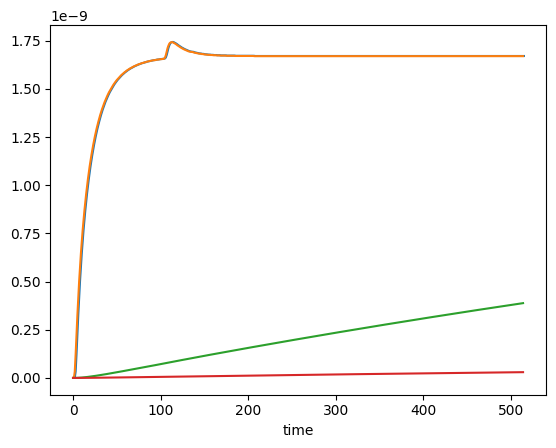

In [27]:
specific_data['Conc'].plot()
results['Pfas'].plot()
results['Pfas_s'].plot()
results['Pfas_aw'].plot()

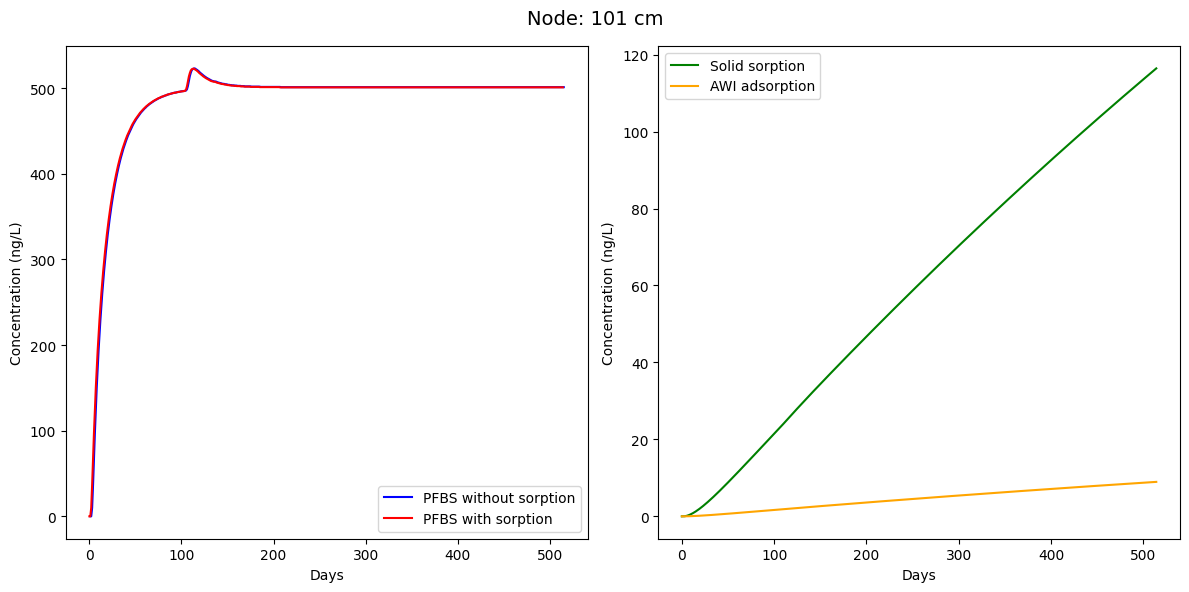

In [ ]:
# Molecular weight of PFBS in grams
mol_weight = 300.1

# Convert concentrations to ng/L
specific_data['Conc_ng_L'] = specific_data['Conc'] * 10**9 * mol_weight
results['Pfas_ng_L'] = results['Pfas'] * 10**9 * mol_weight
results['Pfas_s_ng_L'] = results['Pfas_s'] * 10**9 * mol_weight
results['Pfas_aw_ng_L'] = results['Pfas_aw'] * 10**9 * mol_weight

# Create two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot specific_data on the first subplot
axes[0].plot(specific_data.index, specific_data['Conc_ng_L'], label='PFBS without sorption', color='blue')
axes[0].plot(results.index, results['Pfas_ng_L'], label='PFBS with sorption', color='red')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Concentration (ng/L)')
axes[0].legend()

# Plot results data on the second subplot
axes[1].plot(results.index, results['Pfas_s_ng_L'], label='Solid sorption', color='green')
axes[1].plot(results.index, results['Pfas_aw_ng_L'], label='AWI adsorption', color='orange')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Concentration (ng/L)')
axes[1].legend()
fig.suptitle('Node: 101 cm', fontsize=14)
# Adjust layout
plt.tight_layout()
plt.savefig('../Figures/101_node_phreeqc.png', dpi=600, bbox_inches='tight') # change with your desired output Figures folder
plt.show()